1. Importando os pacotes

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"


2. Carregando os dados

In [16]:
dados_ecommerce = pd.read_csv('data.csv', encoding= 'unicode_escape', sep=',')

3. Entendendo os dados

In [17]:
# Informações gerais das colunas e tipo das variáveis
dados_ecommerce.info()

# Estatistica descritiva das variáveis
tab_desc = dados_ecommerce.describe()

# Somando total de valores nulos 

porc_nulos_costumerID = (dados_ecommerce['CustomerID'].isna().sum() / len(dados_ecommerce['CustomerID'])) * 100
porc_nulos_description = (dados_ecommerce['Description'].isna().sum() / len(dados_ecommerce['CustomerID'])) * 100
print('{:.2f}%, {:.2f}%'.format(porc_nulos_costumerID,porc_nulos_description))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
24.93%, 0.27%


- Missing em CostumerID (24,93%) e Description (0,27%)
- Valores negativos em Quantity e UnitPrice
- InvoiceDate deveria ser tipo date

4. Preparação dos dados e limpeza

In [18]:
# Removendo os valores missings

dados_ecommerce.drop(dados_ecommerce[dados_ecommerce['CustomerID'].isna() | dados_ecommerce['Description'].isna()].index, inplace=True)
dados_ecommerce.info()

# Removendo valores de Quantity e UnitPrice negativos

dados_ecommerce.drop(dados_ecommerce[dados_ecommerce['Quantity']<0].index, inplace=True)
dados_ecommerce.describe()

# Ajustando tipos de dados errados

dados_ecommerce['InvoiceDate']=pd.to_datetime(dados_ecommerce['InvoiceDate'])

dados_ecommerce['CustomerID'] = dados_ecommerce['CustomerID'].astype('int')

dados_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64       

- RFM: A análise RFM, sigla para Recency, Frequency, Monetary, é uma metodologia fundamental no campo do marketing e gestão de clientes. Ela envolve a avaliação detalhada do comportamento dos clientes com base em três critérios essenciais: recência, frequência e valor monetário. A análise RFM permite que as empresas segmentem sua base de clientes em grupos distintos, auxiliando na compreensão das características e preferências dos consumidores.

In [19]:
# Calculando Recência: Há quanto tempo os clientes compraram?

dados_ecommerce['Rank'] = dados_ecommerce.sort_values(['CustomerID','InvoiceDate']).groupby(['CustomerID'])['InvoiceDate'].rank(method='min').astype(int)
primeiras_compras = dados_ecommerce[dados_ecommerce['Rank']==1]

data_primeira_compra = pd.to_datetime(min(primeiras_compras['InvoiceDate']))
primeiras_compras['Recencia'] = (primeiras_compras['InvoiceDate'] - data_primeira_compra).dt.days

C:\Users\Eric\AppData\Local\Temp\ipykernel_4664\3308839523.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- O código nos permite calcular a recência com base na primeira interação de cada cliente com a empresa. Isso proporciona uma medida precisa de quanto tempo se passou desde a primeira compra de cada cliente até a data de referência atual (primeira compra mais antiga), o que é essencial para entender e segmentar clientes com base em seu comportamento de compra recente.

In [20]:
# Calculando a Frequência: Com que frequência os clientes compram?
freq = primeiras_compras.groupby('CustomerID')['InvoiceDate'].count()
freq_df = pd.DataFrame(freq).reset_index()
freq_df.columns = ['CustomerID', 'Frequencia']
freq_df.head()

,CustomerID,Frequencia
0,12346,1
1,12347,31
2,12348,17
3,12349,73
4,12350,17


In [21]:
# Juntando os dataframes
rec_freq = freq_df.merge(primeiras_compras, on= 'CustomerID')
rec_freq.head()

,CustomerID,Frequencia,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Rank,Recencia
0,12346,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,1,48
1,12347,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,1,6
2,12347,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,1,6
3,12347,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,1,6
4,12347,31,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,1,6


In [22]:
# Monetário: Quanto os clientes gastam? 
rec_freq['Total'] = rec_freq['Quantity'] * rec_freq['UnitPrice']
m = rec_freq.groupby('CustomerID')['Total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID', 'ValorMonetario']
m.head()


,CustomerID,ValorMonetario
0,12346,77183.60
1,12347,711.79
2,12348,892.80
3,12349,1757.55
4,12350,334.40


In [23]:
# Juntando o valor monetario ao df e criando um somente com rfm e CustomerID
rfm = m.merge(rec_freq, on='CustomerID')
final_df = rfm[['CustomerID', 'Recencia', 'Frequencia', 'ValorMonetario']]
final_df.head()


,CustomerID,Recencia,Frequencia,ValorMonetario
0,12346,48,1,77183.60
1,12347,6,31,711.79
2,12347,6,31,711.79
3,12347,6,31,711.79
4,12347,6,31,711.79


In [24]:
#Retirando valores duplicados
final_df.drop_duplicates(inplace=True)

# Removendo a coluna CustomerID
final_df.drop(columns='CustomerID', inplace=True)

C:\Users\Eric\AppData\Local\Temp\ipykernel_4664\3768545056.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Eric\AppData\Local\Temp\ipykernel_4664\3768545056.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
# Outliers 

var_boxplot = ['Recencia', 'Frequencia', 'ValorMonetario']


for i in var_boxplot:
    print(str(i)+': ')
    fig = px.box(final_df,
                x = final_df[i])
    fig.show()


Recencia: 
Frequencia: 
ValorMonetario: 


- Vemos que visualmente há presença de outliers nas variáveis ValorMonetário e Frequência.

In [27]:
# Calculando os limites inferior e superior usando o IQR
Q1 = final_df.quantile(0.25)
Q3 = final_df.quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrando os outliers
filtered_df = final_df[~((final_df < lower_bound) | (final_df > upper_bound)).any(axis=1)]

# Resetando o índice
filtered_df = filtered_df.reset_index(drop=True)

# Exibindo o novo DataFrame filtrado
filtered_df.head()

,Recencia,Frequencia,ValorMonetario
0,6,31,711.79
1,63,17,334.40
2,77,15,296.50
3,169,4,89.00
4,159,13,459.40


5. Padronização
- É importante realizar a análise das unidades de medidas, assim, visto que as que estamos trabalhando possuem unidades distintas é necessário a padronização das mesmas.

In [31]:
# Padronização pelo z-score
df_pad = filtered_df.apply(zscore, ddof=1)
# Visualizando o resultado do procedimento na média e desvio padrão
print(round(df_pad.mean(), 3))
print(round(df_pad.std(), 3))


Recencia         -0.0
Frequencia       -0.0
ValorMonetario   -0.0
dtype: float64
Recencia          1.0
Frequencia        1.0
ValorMonetario    1.0
dtype: float64


6. Construindo o Modelo

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_i

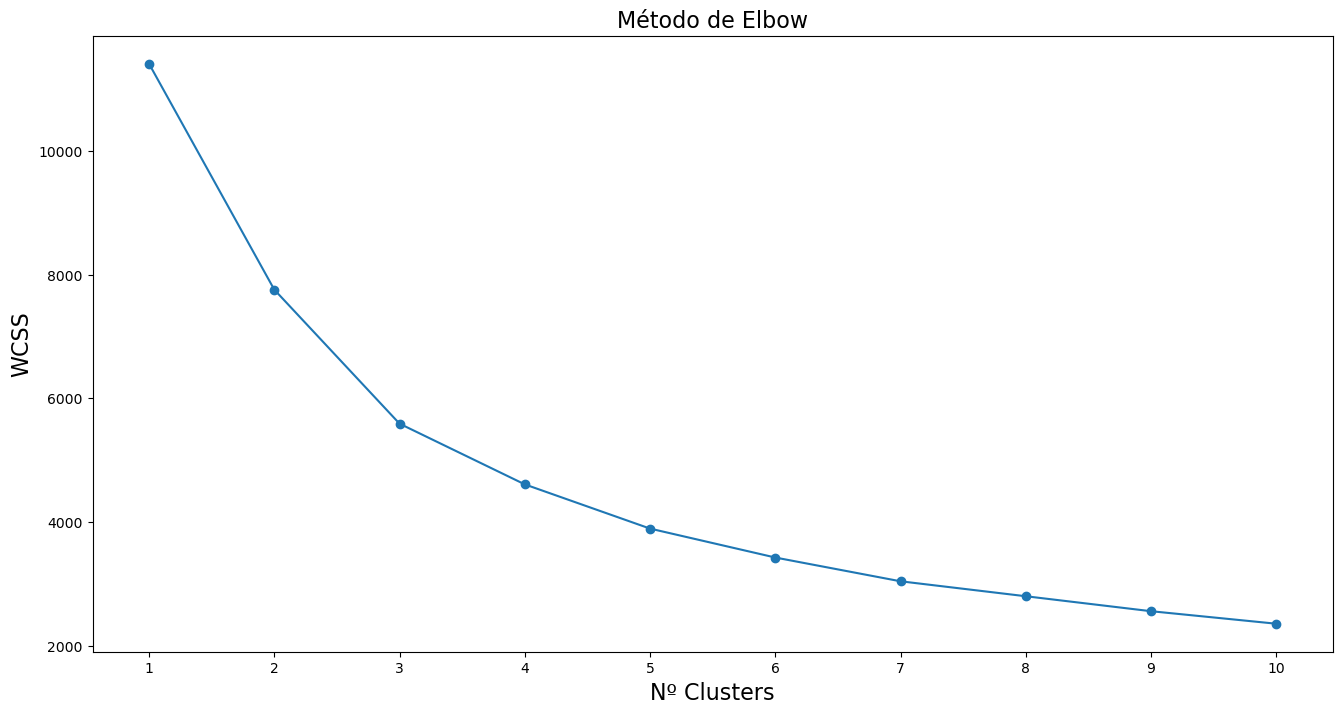

In [32]:
#%% Identificação da quantidade de clusters (Método Elbow)

elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(df_pad)
    elbow.append(kmeanElbow.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_i

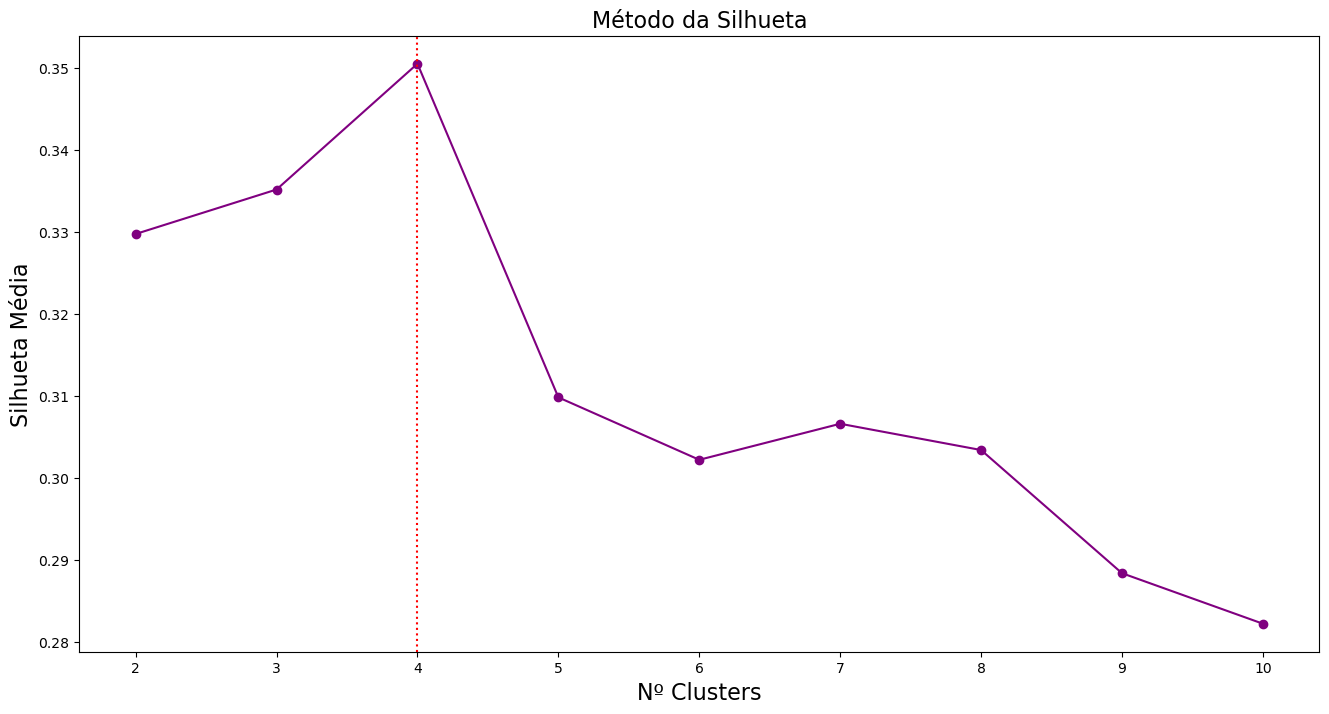

In [35]:
#%% Identificação da quantidade de clusters (Método da Silhueta)

silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(df_pad)
    silhueta.append(silhouette_score(df_pad, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()


- De acordo com os métodos, o melhor número de clusters para ser utilizado no K-means é de 4.

In [36]:
# Cluster Não Hierárquico K-means

# Vamos considerar 4 clusters, considerando as evidências anteriores!

kmeans_final = KMeans(n_clusters = 4, init = 'random', random_state=100).fit(df_pad)

# Gerando a variável para identificarmos os clusters gerados

kmeans_clusters = kmeans_final.labels_
filtered_df['cluster_kmeans'] = kmeans_clusters
df_pad['cluster_kmeans'] = kmeans_clusters
filtered_df['cluster_kmeans'] = filtered_df['cluster_kmeans'].astype('category')
df_pad['cluster_kmeans'] = df_pad['cluster_kmeans'].astype('category')

c:\Users\Eric\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



7. Conlusão

In [39]:
mean_df = filtered_df.groupby(['cluster_kmeans'], as_index=False).mean()
for i in filtered_df.columns:
    print(i)
    fig = px.bar(mean_df,
                x='cluster_kmeans',
                y=str(i))
    fig.show()

Recencia
Frequencia
ValorMonetario
cluster_kmeans


- Cluster 0: Consumidores que possuem alta frquência e recência moderada. São consumidores que compram com muita frequência e que não são tão novos nem antigos. Uma boa estratégia seria o entendimento do que esses consumidores mais compram e personalizar uma recomendação com produtos de maior valor agregado que estão relacionados de acordo com outros dados.
- Cluster 1: Menor valor monetário, menor frequência e menor recência. São consumidores que não compram com muita frequência e que não engajaram recentemente. São consumidores mais antigos e que compram com pouca frequência, assim pode-se fazer 
- Cluster 2: Maior recência. São consumidores que tem a maior recência, então são consumidores que engajaram recentemente, ou seja, consumidores novos, assim uma pesquisas de satisfação com coleta de feedback para entender suas necessidades e ajustar as estratégias para esse grupo seria uma boa. Também, enviar um email de boas-vindas e um desconto de 10% na próxima compra para ajudar na fidelização desse grupo e sugerir outros produtos compatíveis com sua última compra.
- Cluster 3: Maior valor monetário e segunda maior frequência. Esse grupo de consumidores são o grupo que mais gastaram com os produtos, também são consumidores que compram com uma boa frequência, assim elaborar níveis de fidelidade (bronze, prata, ouro) que ofereçam benefícios crescentes para incentivar ainda mais compras e lealdade.
- Valor monetário entre os clusters 0, 1 e 2 são muito próximos.